In [1]:
import treeswift
import numpy as np
import pandas as pd
import os
from utils import *

In [2]:
def read_trees(path, recCA=False, exclude_taxon='ghost'):
    '''
    Read in the trees file and return a dictionary with the state as the key and the tree as the value
    '''
    trees = treeswift.read_tree_nexus(path)
    # create an updated trees dictionary after removing "STATE_" from each key 
    updated_trees = {}
    for key in trees:
        if 'STATE_' in key:
            tree = trees[key]
            if recCA == False:
                updated_trees[int(key[6:])] = tree
            elif recCA == True: # if recCA, extract subtree that excludes ghost lineage
                new_tree = tree.extract_tree_without([exclude_taxon])
                updated_trees[int(key[6:])] = new_tree
        else:
            updated_trees[key] = trees[key]
    return updated_trees


def read_states(path):
    '''
    Read in the states file and return a dataframe with the state and the sequence
    '''
    states = pd.read_csv(path, sep='\t', header=None, comment='#')
    states.columns = ['state', 'sequence']
    try:
        states = states[~states['state'].str.contains('state')]
    except:
        # states = states
        pass 
    states['state'] = states['state'].apply(lambda x: int(x))
    states['lineage'] = states['sequence'].apply(lambda x: get_lineage(x))
    return states


def get_lineage_mrca(tree, lineage_dict):
    '''
    Returns a dictionary with the lineage as the key and the MRCA of the taxa with that lineage as the value
    
    Parameters:
    tree (Tree): the tree
    lineage_dict (Dict): a dictionary with the lineage as the key and all taxa with that lineage as the value
    
    Returns:
    Dict: a dictionary with the lineage as the key and the MRCA of the taxa with that lineage as the value
    '''
    mrca_dict = {}
    for key in lineage_dict:
        if key == 'unknown':
            continue
        taxa = lineage_dict[key]
        mrca = tree.mrca(taxa)
        mrca_dict[key] = mrca

        if key == 'TT':
            for taxon in taxa:
                mrca_dict[taxon] = tree.mrca([taxon]) # this is the node itself; it's for compatibility because there isn't a function in treeswift that returns the node given its label
    return mrca_dict


def subtree_taxa(tree, node, taxa):
    '''
    Returns whether the taxa are in the subtree with the given node as the root

    Parameters:
    tree (Tree): the tree
    node (Node): the root of the subtree
    taxa (List): the taxa to check

    Returns:
    Boolean: whether the taxa are in the subtree
    '''

    # subtree = tree.extract_subtree(node)
    subtree_taxa = {n.label for n in node.traverse_leaves()} # this is traversing the leaves below this node
    return all([taxon in subtree_taxa for taxon in taxa])


def locate_tt(tree, mrca_lineage, lineage_dict, state=None):
    '''
    Determines whether the T/T lineage is between A and B, or if it is a descendant of A or B
    
    Parameters:
    tree (Tree): the tree
    mrca_lineage (String): the lineage of the MRCA of A and B
    lineage_dict (Dict): a dictionary with the lineage as the key and all taxa with that lineage as the value
    state (String): the state of the tree
    
    Returns:
    Boolean: whether A is monophyletic
    Boolean: whether B is monophyletic
    Boolean: whether T/T is monophyletic
    Boolean: when T/T is a true intermediate, the parent haplotype is 'intermediate'; otherwise, the parent haplotypes of T/T
    '''

    lineage_mrca_dict = get_lineage_mrca(tree, lineage_dict)
    # a_size, b_size = tree.extract_subtree(lineage_mrca_dict['A']).num_nodes(internal=False), tree.extract_subtree(lineage_mrca_dict['B']).num_nodes(internal=False)
    a_size, b_size = len(list(lineage_mrca_dict['A'].traverse_leaves())), len(list(lineage_mrca_dict['B'].traverse_leaves()))

    num_leaves = len(list(tree.traverse_leaves())) # quick way to check whether A or B is not monophyletic but also not the root
    if a_size > 285 and a_size < num_leaves:
        print('A is not monophyletic, not the root, and evolved multiple times!', state)
    if b_size > 585 and b_size < num_leaves:
        print('B is not monophyletic, not the root, and evolved multiple times!', state)
        
    tt_monophyletic = True
    true_intermediate = False
    
    # determine if T/T is monophyletic and whether to examine parents of individual T/T genomes or parent of the MRCA of T/T genomes
    tt_genomes = lineage_dict['TT']
    tt_options = ['TT']
    # if tree.extract_subtree(lineage_mrca_dict['TT']).num_nodes(internal=False) != 2:
    #     tt_monophyletic = False
    #     tt_options = tt_genomes
    if len(list(lineage_mrca_dict['TT'].traverse_leaves())) != 2:
        tt_monophyletic = False
        tt_options = tt_genomes

    # determining whether T/T is between A and B; this does not depend on the monophyly of T/T -- only the parent of either a T/T genome or the parent of the MRCA of the T/T genomes
    if mrca_lineage == 'A':
        for tt_option in tt_options:
            if lineage_mrca_dict['B'] in lineage_mrca_dict[tt_option].parent.children:
                # print('A is ancestral haplotype, and B is a descendant of the parent of the mrca of T/T!', state)
                true_intermediate = True
                break

    elif mrca_lineage == 'B':
        for tt_option in tt_options:
            if lineage_mrca_dict['A'] in lineage_mrca_dict[tt_option].parent.children:
                # print('B is ancestral haplotype, and A is a descendant of the parent of the mrca of T/T!', state)
                true_intermediate = True
                break

    elif mrca_lineage == 'TT':
        for tt_option in tt_options:
            if lineage_mrca_dict['A'] in lineage_mrca_dict[tt_option].parent.children:
                # print('T/T is ancestral haplotype, and A is a descendant of the parent of the mrca of T/T!', state)
                true_intermediate = True
                break
            elif lineage_mrca_dict['B'] in lineage_mrca_dict[tt_option].parent.children:
                # print('T/T is ancestral haplotype, and B is a descendant of the parent of the mrca of T/T!', state)
                true_intermediate = True
                break
    
    elif mrca_lineage == 'CC':
        for tt_option in tt_options:
            if lineage_mrca_dict['A'] in lineage_mrca_dict[tt_option].parent.children:
                # print('C/C is ancestral haplotype, and A is a descendant of the parent of the mrca of T/T!', state)
                true_intermediate = True
                break
            elif lineage_mrca_dict['B'] in lineage_mrca_dict[tt_option].parent.children:
                # print('C/C is ancestral haplotype, and B is a descendant of the parent of the mrca of T/T!', state)
                true_intermediate = True
                break

    # if T/T is a true intermediate, then the parent haplotypes are 'intermediate'
    # otherwise, determine the parent haplotype(s) of T/T -- there are two T/T genomes, so there could be up to two parent haplotypes
    if true_intermediate:
        parent_haplotypes = 'intermediate'
    else:
        parent_haplotypes = []
        if tt_monophyletic:
            part_of_a = subtree_taxa(tree, lineage_mrca_dict['A'], tt_genomes)
            part_of_b = subtree_taxa(tree, lineage_mrca_dict['B'], tt_genomes)
            if part_of_a and not part_of_b:
                parent_haplotypes.append('A')
            elif part_of_b and not part_of_a:
                parent_haplotypes.append('B')
            elif part_of_a and part_of_b: # this is the case where there is an A or B polytomy at the base of the tree; the smaller clade is the parent haplotype
                if a_size > b_size: # check with Marc
                    parent_haplotypes.append('B')
                elif b_size > a_size:
                    parent_haplotypes.append('A')
                else:
                    print('Need to check this case!', state) # something is wrong if the sizes are equal
            else:
                if mrca_lineage == 'A': # ancestral haplotype of A and then these occur on the branch leading to the MRCA of A
                    parent_haplotypes.append('A')
                elif mrca_lineage == 'B': # ancestral haplotype of B and then these occur on the branch leading to the MRCA of B
                    parent_haplotypes.append('B')
                elif mrca_lineage == 'TT': # should never reach this case
                    import ipdb; ipdb.set_trace()
                    parent_haplotypes.append('TT')
                elif mrca_lineage == 'CC': # should never reach this case
                    import ipdb; ipdb.set_trace()
                    parent_haplotypes.append('CC')
            if len(parent_haplotypes) == 0:
                parent_haplotypes = ['unknown']
        else:
            for tt in tt_genomes:
                part_of_a = subtree_taxa(tree, lineage_mrca_dict['A'], [tt])
                part_of_b = subtree_taxa(tree, lineage_mrca_dict['B'], [tt])
                if part_of_a and not part_of_b:
                    parent_haplotypes.append('A')
                elif part_of_b and not part_of_a:
                    parent_haplotypes.append('B')
                elif part_of_a and part_of_b: # this is the case where there is an A or B polytomy at the base of the tree; the smaller clade is the parent haplotype
                    if a_size > b_size:
                        if a_size != tree.num_nodes(internal=False):
                            print('Need to check this case, a_size does not equal tree num nodes!', state) # something is wrong if size of A is not equal to the size of the tree
                            # import ipdb; ipdb.set_trace()
                            tree.write_tree_nexus('%s_tree.nexus' % state)
                        parent_haplotypes.append('B')
                    elif b_size > a_size:
                        if b_size != tree.num_nodes(internal=False):
                            print('Need to check this case, b_size does not equal tree num nodes!', state) # something is wrong if size of B is not equal to the size of the tree
                            # import ipdb; ipdb.set_trace()
                            tree.write_tree_nexus('%s_tree.nexus' % state)
                        parent_haplotypes.append('A')
                    else:
                        print('Need to check this case!', state) # something is wrong if the sizes are equal
                else:
                    # import ipdb; ipdb.set_trace()
                    if mrca_lineage == 'A': # ancestral haplotype of A and then these occur on the branch leading to the MRCA of A 
                        parent_haplotypes.append('A')
                    elif mrca_lineage == 'B': # ancestral haplotype of B and then these occur on the branch leading to the MRCA of B
                        parent_haplotypes.append('B')
                    elif mrca_lineage == 'TT': # should never reach this case
                        import ipdb; ipdb.set_trace()
                        parent_haplotypes.append('TT')
                    elif mrca_lineage == 'CC': # should never reach this case
                        import ipdb; ipdb.set_trace()
                        parent_haplotypes.append('CC')
            if len(parent_haplotypes) != 2:
                # import ipdb; ipdb.set_trace()
                parent_haplotypes = ['unknown']
        parent_haplotypes = ','.join(sorted(set(parent_haplotypes)))

    return tt_monophyletic, parent_haplotypes


def states_tt_results(trees, lineage_dict, states_path):
    '''
    Run the analysis on the trees and states
    
    Parameters:
    trees (Dict): a dictionary with the state as the key and the tree as the value
    lineage_dict (Dict): a dictionary with the lineage as the key and all taxa with that lineage as the value
    states_path (String): the path to the states file
    
    Returns:
    DataFrame: the states dataframe with the tt_between_ab column
    '''
    states = read_states(states_path)

    tt_monophyletic_results = []
    tt_ancestry_results = []
    fails = []
    for state in trees:
        if type(state) != int:
            continue

        mrca_lineage = states[states['state'] == state]['lineage'].values[0]
        # mrca_lineage = states[states['state'] == state]['lineage'].item()
        try:
            tt_monophyletic, tt_ancestry = locate_tt(trees[state], mrca_lineage, lineage_dict, state)
            tt_monophyletic_results.append(tt_monophyletic)
            tt_ancestry_results.append(tt_ancestry)
            if tt_ancestry == 'unknown':
                print('Unknown, need to check this case!', state, mrca_lineage, tt_monophyletic, tt_ancestry)
                # import ipdb; ipdb.set_trace()
                fails.append([state, trees[state], mrca_lineage, tt_monophyletic, tt_ancestry])
        except:
            print('Error in state', state, 'skipping')
            # import ipdb; ipdb.set_trace()
            tt_monophyletic_results.append('ERROR')
            tt_ancestry.append('ERROR')
            fails.append([state, trees[state], mrca_lineage, 'ERROR', 'ERROR', 'ERROR'])
    
    states['tt_monophyletic'] = tt_monophyletic_results
    states['tt_ancestry'] = tt_ancestry_results
    
    return states, pd.DataFrame(fails, columns=['state', 'tree', 'mrca_lineage', 'tt_monophyletic', 'tt_ancestry'])


def run_analysis(trees_path, lineage_dict, states_path, recCA=False, exclude_taxon='ghost', burnin=0.1):
    '''
    Run the analysis on the trees and states
    
    Parameters:
    trees_path (String): the path to the trees file
    lineage_dict (Dict): a dictionary with the lineage as the key and all taxa with that lineage as the value
    states_path (String): the path to the states file
    recCA (Boolean): whether the trees are recCA trees
    exclude_taxon (String): the taxon to exclude from the trees
    
    Returns:
    DataFrame: the states dataframe with the tt_between_ab column
    '''
    trees = read_trees(trees_path, recCA=recCA, exclude_taxon=exclude_taxon)
    states, fails = states_tt_results(trees, lineage_dict, states_path)
    states = states[states['state'] > (burnin * states['state'].max())]
    states.columns = ['state', 'sequence', 'ancestral_haplotype', 'tt_monophyletic', 'tt_ancestry']

    return states[['state', 'ancestral_haplotype', 'tt_monophyletic', 'tt_ancestry']], fails


def run_all_analyses(trees_paths, states_paths, fasta_path, recCA=False, exclude_taxon='ghost', burnin=0.1, redo=False):
    '''
    Run the analysis on the trees and states
    
    Parameters:
    trees_paths (List): a list of paths to the trees files
    states_path (String): the path to the states file
    recCA (Boolean): whether the trees are recCA trees
    exclude_taxon (String): the taxon to exclude from the trees
    '''
    fasta = readFASTA(fasta_path)

    lineage_dict = {}
    for key in fasta:
        lin = get_lineage(fasta[key])
        if lin in lineage_dict:
            lineage_dict[lin].append(key)
        else:
            lineage_dict[lin] = [key]
    
    for index, trees_path in enumerate(trees_paths):
        intermediate_results_path = trees_path.replace('.trees', '.intermediatesResults.csv')
        intermediate_fails_path = trees_path.replace('.trees', '.intermediatesFails.csv')
        if os.path.exists(intermediate_results_path) and not redo:
            print('Intermediate results already exist for', trees_path, 'skipping')
            continue

        print('Running analysis on', trees_path)
        states_path = states_paths[index]
        states, fails = run_analysis(trees_path, lineage_dict, states_path, recCA=recCA, exclude_taxon=exclude_taxon, burnin=burnin)
        states.to_csv(intermediate_results_path, index=False)
        fails.to_csv(intermediate_fails_path, index=False)




# Run analysis (subset/resampled and full analyses)

In [3]:
fasta_path = '../data/2024.WHO_Lv2024.masked.noAmbigs.fasta'

unconstrained_trees_paths = ['../market_unconstrained/run1/global.Lv2024.masked.GLM.HKY.trees',
                            '../market_unconstrained/run2/global.Lv2024.masked.GLM.HKY.trees',
                            '../market_unconstrained/run3/global.Lv2024.masked.GLM.HKY.trees',
                            '../market_unconstrained/run4/global.Lv2024.masked.GLM.HKY.trees']


unconstrained_states_paths = ['../market_unconstrained/run1/global.Lv2024.masked.GLM.HKY.asr.states.log',
                                '../market_unconstrained/run2/global.Lv2024.masked.GLM.HKY.asr.states.log',
                                '../market_unconstrained/run3/global.Lv2024.masked.GLM.HKY.asr.states.log',
                                '../market_unconstrained/run4/global.Lv2024.masked.GLM.HKY.asr.states.log']

recCA_trees_paths = ['../market_recCA/run1/global.Lv2024.masked.GLM.HKY.recCA_GARD.trees',
                    '../market_recCA/run2/global.Lv2024.masked.GLM.HKY.recCA_GARD.trees',
                    '../market_recCA/run3/global.Lv2024.masked.GLM.HKY.recCA_GARD.trees',
                    '../market_recCA/run4/global.Lv2024.masked.GLM.HKY.recCA_GARD.trees']

recCA_states_paths = ['../market_recCA/run1/global.Lv2024.masked.GLM.HKY.recCA_GARD.states.log',
                        '../market_recCA/run2/global.Lv2024.masked.GLM.HKY.recCA_GARD.states.log',
                        '../market_recCA/run3/global.Lv2024.masked.GLM.HKY.recCA_GARD.states.log',
                        '../market_recCA/run4/global.Lv2024.masked.GLM.HKY.recCA_GARD.states.log']

run_all_analyses(unconstrained_trees_paths, unconstrained_states_paths, fasta_path, recCA=False, exclude_taxon='ghost', burnin=0.1, redo=False)
run_all_analyses(recCA_trees_paths, recCA_states_paths, fasta_path, recCA=True, exclude_taxon='ghost', burnin=0.1, redo=False)

Intermediate results already exist for ../market_unconstrained/run1/global.Lv2024.masked.GLM.HKY.trees skipping
Intermediate results already exist for ../market_unconstrained/run2/global.Lv2024.masked.GLM.HKY.trees skipping
Intermediate results already exist for ../market_unconstrained/run3/global.Lv2024.masked.GLM.HKY.trees skipping
Intermediate results already exist for ../market_unconstrained/run4/global.Lv2024.masked.GLM.HKY.trees skipping
Intermediate results already exist for ../market_recCA/run1/global.Lv2024.masked.GLM.HKY.recCA_GARD.trees skipping
Intermediate results already exist for ../market_recCA/run2/global.Lv2024.masked.GLM.HKY.recCA_GARD.trees skipping
Intermediate results already exist for ../market_recCA/run3/global.Lv2024.masked.GLM.HKY.recCA_GARD.trees skipping
Intermediate results already exist for ../market_recCA/run4/global.Lv2024.masked.GLM.HKY.recCA_GARD.trees skipping


# Load and examine results

In [4]:
def combine_results(results_paths):
    results = pd.read_csv(results_paths[0])
    for path in results_paths[1:]:
        results = pd.concat([results, pd.read_csv(path)])
    return results


def convert_table(df):
    '''
    Summarize the results of the analysis, broken down by ancestral haplotype and the parent haplotype of the T/T genomes
    '''
    
    # for each unique value of tt_child_of, make a new column and give it a 1 or 0 based on the value of tt_child_of for that row
    df_edited = pd.get_dummies(df, columns=['tt_ancestry'])
    # get rid of state column
    df_edited = df_edited.drop(columns=['state'])
    # group the results by ancestral haplotype and divide by frequency of that haplotype using agg
    df_grouped = df_edited.groupby('ancestral_haplotype').agg('sum')
    # add column for total number of trees for each ancestral haplotype
    df_grouped['total'] = df_edited.groupby('ancestral_haplotype').size()
    # add row of sum of each column
    df_grouped.loc['total'] = df_grouped.sum()
    # reorder to make total column first 
    cols = df_grouped.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_grouped = df_grouped[cols]

    # rename the columns
    new_col_names = []
    for col in df_grouped.columns.tolist():
        col = col.split('ancestry')[-1].split('_')[-1]
        if 'total' in col or 'monophyletic' in col or 'intermediate' in col:
            col = col.capitalize()
        else:
            col = 'Derived from ' + ' and '.join(col.split(','))
        new_col_names.append(col)
    reordered_col_names = [x for x in ['Total', 'Monophyletic', 'Intermediate', 'Derived from A', 'Derived from B', 'Derived from A and B'] if x in new_col_names]
    
    df_grouped.columns = new_col_names
    df_grouped = df_grouped[reordered_col_names]
    
    # rename the indices
    df_grouped.index.name = 'Ancestral haplotype'
    df_grouped = df_grouped.rename(index={'A': 'A', 'B': 'B', 'TT': 'T/T', 'CC': 'C/C', 'total': 'Total'})

    # double check that all columns except for "Monophyletic" add up to the total column
    for index in df_grouped.index:
        total = df_grouped.loc[index, 'Total']
        sum_columns = df_grouped.loc[index, 'Intermediate':].sum()
        assert total == sum_columns, 'Error in ' + index

    # for every column besides the total column, divide by the total number of trees for each ancestral haplotype, return the count with the percentage in parenthesis, but only to 3 decimal points
    for col in df_grouped.columns:
        if col != 'Total':
            df_grouped[col] = df_grouped[col].astype(str) + ' (' + (df_grouped[col]/df_grouped['Total']*100).round(1).astype(str) + '%)'

    return df_grouped


unconstrained_results_path = ['../market_unconstrained/run1/global.Lv2024.masked.GLM.HKY.intermediatesResults.csv',
                              '../market_unconstrained/run2/global.Lv2024.masked.GLM.HKY.intermediatesResults.csv',
                            '../market_unconstrained/run3/global.Lv2024.masked.GLM.HKY.intermediatesResults.csv',
                            '../market_unconstrained/run4/global.Lv2024.masked.GLM.HKY.intermediatesResults.csv']

recCA_results_path = ['../market_recCA/run1/global.Lv2024.masked.GLM.HKY.recCA_GARD.intermediatesResults.csv',
                    '../market_recCA/run2/global.Lv2024.masked.GLM.HKY.recCA_GARD.intermediatesResults.csv',
                    '../market_recCA/run3/global.Lv2024.masked.GLM.HKY.recCA_GARD.intermediatesResults.csv',
                    '../market_recCA/run4/global.Lv2024.masked.GLM.HKY.recCA_GARD.intermediatesResults.csv']


unconstrained_results = combine_results(unconstrained_results_path)
recCA_results = combine_results(recCA_results_path)

unconstrained_results_table = convert_table(unconstrained_results)
recCA_results_table = convert_table(recCA_results)

In [5]:
display(unconstrained_results_table)
display(recCA_results_table)

,Total,Monophyletic,Intermediate,Derived from A,Derived from B,Derived from A and B
Ancestral haplotype,,,,,,
A,737,734 (99.6%),0 (0.0%),260 (35.3%),476 (64.6%),1 (0.1%)
B,5390,5367 (99.6%),20 (0.4%),1817 (33.7%),3546 (65.8%),7 (0.1%)
C/C,2655,2643 (99.5%),0 (0.0%),867 (32.7%),1782 (67.1%),6 (0.2%)
T/T,218,216 (99.1%),1 (0.5%),76 (34.9%),140 (64.2%),1 (0.5%)
Total,9000,8960 (99.6%),21 (0.2%),3020 (33.6%),5944 (66.0%),15 (0.2%)


,Total,Monophyletic,Intermediate,Derived from A,Derived from B,Derived from A and B
Ancestral haplotype,,,,,,
A,8216,8140 (99.1%),8 (0.1%),2834 (34.5%),5348 (65.1%),26 (0.3%)
B,83,83 (100.0%),0 (0.0%),26 (31.3%),57 (68.7%),0 (0.0%)
C/C,539,535 (99.3%),0 (0.0%),191 (35.4%),347 (64.4%),1 (0.2%)
T/T,162,160 (98.8%),1 (0.6%),59 (36.4%),102 (63.0%),0 (0.0%)
Total,9000,8918 (99.1%),9 (0.1%),3110 (34.6%),5854 (65.0%),27 (0.3%)


In [6]:
# save tables
# unconstrained_results_table.to_csv('../market_unconstrained/intermediatesResultsTable.csv')
# recCA_results_table.to_csv('../market_recCA/intermediatesResultsTable.csv')

# Sensitivity analyses

In [7]:
paths = ['../dateTests/intermediates/run1/',
        '../dateTests/intermediates/run2/',
        '../dateTests/intermediates/run3/',
        '../dateTests/intermediates/run4/']

analyses = ['global.Lv2024.masked.GLM.HKY.recCA_GARD.04Jan_07Jan.',
            'global.Lv2024.masked.GLM.HKY.recCA_GARD.11Jan_14Jan.',
            'global.Lv2024.masked.GLM.HKY.recCA_GARD.18Jan_21Jan.',
            'global.Lv2024.masked.GLM.HKY.recCA_GARD.1Feb_4Feb.',
            'global.Lv2024.masked.GLM.HKY.recCA_GARD.25Jan_28Jan.',
            'global.Lv2024.masked.GLM.HKY.recCA_GARD.sampledDatesTT.']

for analysis in analyses:
    trees_paths = [path + analysis + 'trees' for path in paths if 'run2/global.Lv2024.masked.GLM.HKY.recCA_GARD.18Jan_21Jan.' not in (path + analysis)]
    states_paths = [path + analysis + 'states.log' for path in paths if 'run2/global.Lv2024.masked.GLM.HKY.recCA_GARD.18Jan_21Jan.' not in (path + analysis)]
    if 'recCA' in analysis:
        recCA = True
    run_all_analyses(trees_paths, states_paths, fasta_path, recCA=recCA, exclude_taxon='ghost', burnin=0.1, redo=False)


Intermediate results already exist for ../dateTests/intermediates/run1/global.Lv2024.masked.GLM.HKY.recCA_GARD.04Jan_07Jan.trees skipping
Intermediate results already exist for ../dateTests/intermediates/run2/global.Lv2024.masked.GLM.HKY.recCA_GARD.04Jan_07Jan.trees skipping
Intermediate results already exist for ../dateTests/intermediates/run3/global.Lv2024.masked.GLM.HKY.recCA_GARD.04Jan_07Jan.trees skipping
Intermediate results already exist for ../dateTests/intermediates/run4/global.Lv2024.masked.GLM.HKY.recCA_GARD.04Jan_07Jan.trees skipping
Intermediate results already exist for ../dateTests/intermediates/run1/global.Lv2024.masked.GLM.HKY.recCA_GARD.11Jan_14Jan.trees skipping
Intermediate results already exist for ../dateTests/intermediates/run2/global.Lv2024.masked.GLM.HKY.recCA_GARD.11Jan_14Jan.trees skipping
Intermediate results already exist for ../dateTests/intermediates/run3/global.Lv2024.masked.GLM.HKY.recCA_GARD.11Jan_14Jan.trees skipping
Intermediate results already exist

In [8]:
paths = ['../dateTests/intermediates/run1/',
        '../dateTests/intermediates/run2/',
        '../dateTests/intermediates/run3/',
        '../dateTests/intermediates/run4/']

analyses = ['global.Lv2024.masked.GLM.HKY.recCA_GARD.04Jan_07Jan.',
            'global.Lv2024.masked.GLM.HKY.recCA_GARD.11Jan_14Jan.',
            'global.Lv2024.masked.GLM.HKY.recCA_GARD.18Jan_21Jan.',
            'global.Lv2024.masked.GLM.HKY.recCA_GARD.25Jan_28Jan.',
            'global.Lv2024.masked.GLM.HKY.recCA_GARD.1Feb_4Feb.',
            'global.Lv2024.masked.GLM.HKY.recCA_GARD.sampledDatesTT.']#,
            # 'global.Lv2024.masked.GLM.HKY.sampledDatesTT.']

output_dir = '../dateTests/intermediates/'

dates = ['2020-01-04', '2020-01-11', '2020-01-18', '2020-01-25', '2020-02-01', '2020-02-08']
analyses_text = []
intermediate_prop = []
for analysis in analyses:
    int_results_paths = [path + analysis + 'intermediatesResults.csv' for path in paths if 'run2/global.Lv2024.masked.GLM.HKY.recCA_GARD.18Jan_21Jan.' not in (path + analysis)]
    results = combine_results(int_results_paths)    
    results_table = convert_table(results)
    results_table.to_csv(output_dir + analysis + 'intermediatesResultsTable.csv')
    # print(analysis)
    if 'ampled' not in analysis:
        intermediate_prop.append(int(results_table.loc['Total', 'Intermediate'].split(' ')[0])/9000)
        analyses_text += [analysis.split('.')[-2]]
intermediate_prop.append(9/9000) # adding the primary analysis

analyses_text += ['08Feb_11Feb']

cumulative_results_df = pd.DataFrame({'Analysis': analyses_text, 'Intermediate proportion': intermediate_prop})
cumulative_results_df

,Analysis,Intermediate proportion
0,04Jan_07Jan,0.639222
1,11Jan_14Jan,0.099889
2,18Jan_21Jan,0.020889
3,25Jan_28Jan,0.008222
4,1Feb_4Feb,0.001556
5,08Feb_11Feb,0.001000


In [9]:
paths = ['../dateTests/intermediates/run1/',
        '../dateTests/intermediates/run2/',
        '../dateTests/intermediates/run3/',
        '../dateTests/intermediates/run4/']

analyses = ['global.Lv2024.masked.GLM.HKY.recCA_GARD.sampledDatesTT.']

def read_logs(paths, burnin=0.1):
    '''
    Read in the log files 
    '''
    df = pd.DataFrame()
    for path in paths:
        log = pd.read_csv(path, sep='\t', comment='#')
        log = log.iloc[int(burnin * log.shape[0])+1:]
        df = pd.concat([df, log])
    return df


tmrca_df = pd.DataFrame()
for analysis in analyses:
    log_paths = [path + analysis + 'log' for path in paths if 'run2/global.Lv2024.masked.GLM.HKY.recCA_GARD.18Jan_21Jan.' not in (path + analysis)]
    log_df = read_logs(log_paths)
    tmrca_hpd = hpd_single(log_df['age(realData)'], alpha=0.05)
    tmrca = log_df[(log_df['age(realData)'] >= tmrca_hpd[0]) & (log_df['age(realData)'] <= tmrca_hpd[1])][['age(realData)']].copy()
    tmrca.columns = ['date']
    tmrca['analysis'] = analysis.split('.')[-2]
    tmrca_df = pd.concat([tmrca_df, tmrca])
    
    if 'ample' in analysis:
        tip_age_1_hpd = hpd_single(log_df['age(hCoV-19/Shanghai/SH-P37-2-Shanghai/2020|OR240485|NA)'], alpha=0.05)
        tip_age_2_hpd = hpd_single(log_df['age(hCoV-19/Shanghai/SH-P55-2-Other-province-of-China-Henan/2020|OR240519|NA)'], alpha=0.05)
        tip_age_1 = toYearFraction('2020-02-14') - log_df[(log_df['age(hCoV-19/Shanghai/SH-P37-2-Shanghai/2020|OR240485|NA)'] >= tip_age_1_hpd[0]) & (log_df['age(hCoV-19/Shanghai/SH-P37-2-Shanghai/2020|OR240485|NA)'] <= tip_age_1_hpd[1])][['age(hCoV-19/Shanghai/SH-P37-2-Shanghai/2020|OR240485|NA)']].copy()
        tip_age_2 = toYearFraction('2020-02-14') - log_df[(log_df['age(hCoV-19/Shanghai/SH-P55-2-Other-province-of-China-Henan/2020|OR240519|NA)'] >= tip_age_2_hpd[0]) & (log_df['age(hCoV-19/Shanghai/SH-P55-2-Other-province-of-China-Henan/2020|OR240519|NA)'] <= tip_age_2_hpd[1])][['age(hCoV-19/Shanghai/SH-P55-2-Other-province-of-China-Henan/2020|OR240519|NA)']].copy()
        tip_age_1.columns = ['date']
        tip_age_2.columns = ['date']
        tip_age_1['analysis'] = 'SH-P37-2'
        tip_age_2['analysis'] = 'SH-P55-2'
        tmrca_df = pd.concat([tmrca_df, tip_age_1, tip_age_2])

        print('Tip age 1:', [toDatestring(x) for x in (toYearFraction('2020-02-14') - tip_age_1_hpd)], toDatestring(toYearFraction('2020-02-14') - log_df['age(hCoV-19/Shanghai/SH-P37-2-Shanghai/2020|OR240485|NA)'].median()))
        print('Tip age 2:', [toDatestring(x) for x in (toYearFraction('2020-02-14') - tip_age_2_hpd)], toDatestring(toYearFraction('2020-02-14') - log_df['age(hCoV-19/Shanghai/SH-P55-2-Other-province-of-China-Henan/2020|OR240519|NA)'].median()))


Tip age 1: ['2019-12-23', '2019-11-11'] 2019-12-07
Tip age 2: ['2019-12-23', '2019-11-11'] 2019-12-07


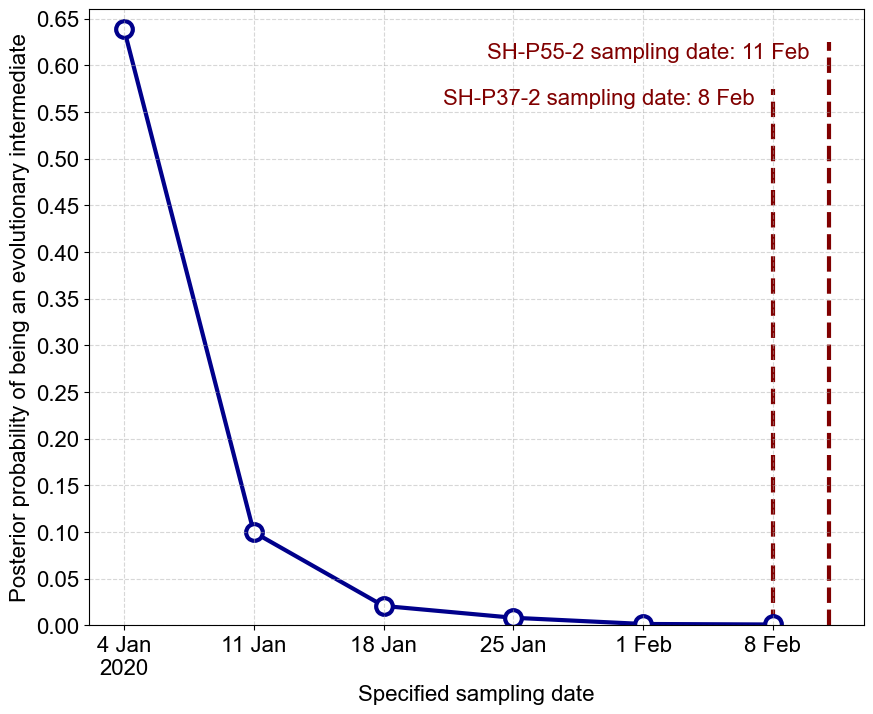

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = "Arial"
fontsize = 16

analyses_dates = ['2020-01-04', '2020-01-11', '2020-01-18', '2020-01-25', '2020-02-01', '2020-02-08']
analyses_dates = [toYearFraction(date) for date in analyses_dates]
analyses_dates_labels = ['4 Jan\n2020', '11 Jan', '18 Jan', '25 Jan', '1 Feb', '8 Feb']

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.plot(analyses_dates, intermediate_prop, linewidth=3, color='darkblue', marker='o', markersize=12, markerfacecolor='white', markeredgewidth=3, zorder=1)
ax.set_ylabel('Posterior probability of being an evolutionary intermediate', fontsize=fontsize)
ax.set_ylim(0, 0.66)
# set all ticks to larger fontsize
yticks = np.arange(0, 0.7, 0.05)
ax.set_yticks(yticks)
ax.tick_params(axis='both', which='major', labelsize=fontsize)

xticks = analyses_dates
ax.set_xticks(xticks, analyses_dates_labels)

# grid
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.grid(axis='x', linestyle='--', alpha=0.5)

# set the vlines
ax.vlines(x=toYearFraction('2020-02-08'), ymin=0, ymax=0.575, color='maroon', linestyle='--', label='Date of earliest sampled genome', linewidth=3, zorder=0)
ax.vlines(x=toYearFraction('2020-02-11'), ymin=0, ymax=0.625, color='maroon', linestyle='--', label='Date of earliest sampled genome', linewidth=3, zorder=0)
ax.text(toYearFraction('2020-02-08')-1/365, 0.575, 'SH-P37-2 sampling date: 8 Feb', 
            fontsize=fontsize, color='maroon', horizontalalignment='right', verticalalignment='top')
ax.text(toYearFraction('2020-02-11')-1/365, 0.625, 'SH-P55-2 sampling date: 11 Feb',
                fontsize=fontsize, color='maroon', horizontalalignment='right', verticalalignment='top')

ax.set_xlabel('Specified sampling date', fontsize=fontsize)

# plt.savefig('../figures/intermediatesResults.png', dpi=300, bbox_inches='tight')

plt.show()